In [26]:
import os
import joblib
import yaml
import zipfile
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# config file
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"

In [27]:
# utils file
with open("../../default_params.yml", "r") as file:
    config = yaml.safe_load(file)

In [ ]:
class Loader:
    def __init__(self, dataset=None, batch_size=24, normalized=True):
        self.dataset = dataset
        self.batch_size = config["dataloader"]["batch_size"]
        self.val_batch_size = batch_size
        self.image_height = config["dataloader"]["image_height"]
        self.image_width = config["dataloader"]["image_width"]
        self.normalized = normalized
        self.p_value = 0.5
        self.normalized_value = 0.5

    def unzip_folder(self):
        with zipfile.ZipFile(self.dataset, "r") as zip_ref:
            if os.path.exists(RAW_DATA_PATH):
                zip_ref.extractall(RAW_DATA_PATH)
            else:
                raise Exception("Could not find the raw data folder".title())

    def _normalized(self):
        if self.normalized:
            return transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Resize((self.image_height, self.image_width)),
                    transforms.CenterCrop((self.image_height, self.image_width)),
                    transforms.RandomVerticalFlip(p=self.p_value),
                    transforms.Normalize(
                        mean=[
                            self.normalized_value,
                            self.normalized_value,
                            self.normalized_value,
                        ],
                        std=[
                            self.normalized_value,
                            self.normalized_value,
                            self.normalized_value,
                        ],
                    ),
                ]
        )

    def create_dataloader(self):
        if os.path.exists(RAW_DATA_PATH):
            dataset = ImageFolder(root=RAW_DATA_PATH, transform=self._normalized())
            dataloader = DataLoader(
                dataset=dataset, batch_size=self.batch_size, shuffle=True
            )

            if os.path.exists(PROCESSED_DATA_PATH):
                joblib.dump(
                    value=dataloader,
                    filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"),
                )
            else:
                raise Exception("Could not find the processed data folder".title())

            return dataloader
        else:
            raise Exception("Could not find the raw data folder".title())


if __name__ == "__main__":
    loader = Loader(
        dataset="./data.zip",
        batch_size=24,
        normalized=True,
    )

    loader.unzip_folder()
    dataloader = loader.create_dataloader()

In [68]:
# unittest
import warnings
warnings.filterwarnings("ignore")

sum(data.size(0) for data, _ in dataloader)

2194

In [69]:
# unittest
data, _ = next(iter(dataloader))
data.shape

torch.Size([1, 3, 256, 512])

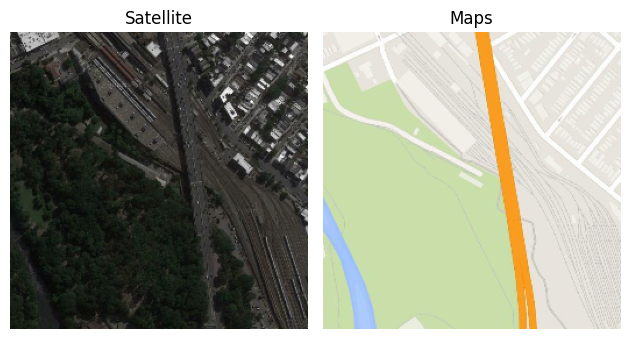

In [71]:
import matplotlib.pyplot as plt

inputs = data[:, :, :, :256]
targets = data[:, :, :, 256:]

inputs = (inputs - inputs.min())/(inputs.max() - inputs.min())
targets = (targets - targets.min())/(targets.max() - targets.min())

plt, axes = plt.subplots(1, 2)

axes[0].imshow(inputs.squeeze().permute(1, 2, 0))
axes[0].set_title("Satellite")
axes[0].set_axis_off()

axes[1].imshow(targets.squeeze().permute(1, 2, 0))
axes[1].set_axis_off()
axes[1].set_title("Maps")

plt.tight_layout()
plt.show()